## Download data source

* Download the data needed for this jupyter notebook from kaggle and store it in a new folder (the-movies-dataset) in the current directory.


* Upon running this cell, the user will be asked for their username and key which can be found in a fresh api token from kaggle.

* Instructions to get api token to authenticate the data request (Note: kaggle account required):
    1. Sign into kaggle.
    2. Go to the 'Account' tab of your user profile and select 'Create New Token'. 
    3. This will trigger the download of kaggle.json, a file containing your API credentials.

* If the folder has been created and the files are already in that folder, than this cell does nothing and requires no credentials.

* Data Source Information: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv


In [1]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

Your Kaggle Key:Downloading the-movies-dataset.zip to ./the-movies-dataset


100%|██████████| 228M/228M [00:23<00:00, 10.2MB/s] 


## Combine Raw Data

Combining certain data from the necessary csv files into a single dataframe (complete_df).

* Rows are removed from each dataframe when they do not have sufficent data for a column or the data from a column does not exist.
* This kind of row removal is done before multiple copies of the same movie data becomes present in multple rows, to save time and space.
* Iteration through rows of a dataframe at this level is inefficient compared to list iteration.
* This is why the dataframes are converted into lists before iteration and then back again to dataframes, so the merge function can be applied to combine the data into a single dataframe (complete_df).

In [2]:
import pandas as pd
import time

start_time = time.time()


pd.set_option('display.max_colwidth', None)

movies_df = pd.read_csv('./the-movies-dataset/movies_metadata.csv',usecols=("genres","id" ,"title","tagline", "overview","production_companies"),
                          dtype={'genres':"string","id":"string","title": "string", "tagline": "string","overview":"string",
                                    "production_companies" :"string"})[["genres","id" ,"title","tagline", "overview","production_companies"]]
movies_df.dropna(inplace = True)
movies_lst = [row for row in movies_df.values.tolist() if not (row[0][len(row[0])  - 2:] == "[]" or row[5][len(row[5]) - 2:] == "[]")]
movies_df = pd.DataFrame(movies_lst, columns = ("genres","id" ,"title","tagline", "overview","production_companies"), dtype = str)



ratings_df = pd.read_csv('./the-movies-dataset/ratings.csv', usecols = ("userId", "movieId", "rating"),
                       dtype={"userId": "string","movieId": "string","rating": "string"})[["userId", "movieId", "rating"]]
ratings_df.rename(columns={"movieId": "id"}, inplace = True)
ratings_df.dropna(inplace = True)


# Question: What if the removal of duplicate movie ids per user was processed here instead of the cell below???
# Answer: The duplicate removal function can be ran here,...
# but the complete_list in the cell below can also be iterated over with relative complexity in order to remove duplicates.
# The iteration in the next cell also populates the gap list...
# which is critical to be ran directly before the function that determines bounds for users rated movies.
# So, omitting the no duplicate function in this cell and making it run in the next cell avoids redundant iteration.


# Question: What if the test and train ratings bounds was enforced here instead of the cell below???
# Answer: The merge functions below needs to be executed before determining test and train users, because merge will remove rows and ratings from users...
# before enforcing the users to be in a certain bounds for the number of their ratings. 
# The current timing of this function will ensure that the final users are within the set train or test bounds.


keywords_df = pd.read_csv('./the-movies-dataset/keywords.csv', usecols = ("id", "keywords"), dtype={"id": "string","keywords":"string"})[["id", "keywords"]]
keywords_df.dropna(inplace = True)
keywords_lst = [row for row in keywords_df.values.tolist() if not (row[1][len(row[1])  - 2:] == "[]")]
keywords_df = pd.DataFrame(keywords_lst, columns = ("id", "keywords"), dtype = str)


credits_df = pd.read_csv("./the-movies-dataset/credits.csv", usecols = ("cast", "id"), dtype={"cast": "string", "id": "string"})[["cast", "id"]]
credits_df.dropna(inplace = True)
credits_lst = [row for row in credits_df.values.tolist() if (not row[0][len(row[0])  - 2:] == "[]")]
credits_df = pd.DataFrame(credits_lst, columns = ("cast", "id"), dtype = str)


# Default merge is inner: This only keeps movies that have the id existing in both dataframes.
complete_df =  pd.merge(movies_df, ratings_df, on ="id")
complete_df =  pd.merge(complete_df,keywords_df, on ="id")
complete_df  = pd.merge(complete_df,credits_df, on ="id")


complete_df.sort_values(by = 'userId', inplace = True)


# Master dataframe: For each (user id, movie id) row combination there is the combined movie data from movies_df, ratings_df, keywords_df, and credits_df for the movie id in question.
# The columns are reordered.
complete_df  = complete_df.loc[:,['userId','id','rating',"title", "genres","production_companies","keywords", "cast", "tagline", "overview" ]]



# For testing:
print("Minutes taken:", (time.time()-start_time)/60)
print(complete_df.head())



# Tested on personal machine:
# Old run with dataframe iteration (old code): 1 minute and 5.7 seconds
# New run with list conversion before iteration (current code): 37.1 seconds

Minutes taken: 0.5886005163192749
        userId    id rating               title  \
6566765      1  1246    5.0        Rocky Balboa   
6880303      1  2959    4.0      License to Wed   
2083077      1  2762    4.5  Young and Innocent   
1492304      1  1968    4.0       Fools Rush In   
2638962      1   147    4.5       The 400 Blows   

                                                                                                genres  \
6566765                                                                  [{'id': 18, 'name': 'Drama'}]   
6880303                                                                 [{'id': 35, 'name': 'Comedy'}]   
2083077                                     [{'id': 18, 'name': 'Drama'}, {'id': 80, 'name': 'Crime'}]   
1492304  [{'id': 18, 'name': 'Drama'}, {'id': 35, 'name': 'Comedy'}, {'id': 10749, 'name': 'Romance'}]   
2638962                                                                  [{'id': 18, 'name': 'Drama'}]   

                      

## Data Extraction and Selection
1. Select data from users that have a number of ratings within a certain bounds.
2. Select a random subset of this data and simplify it.


Complete number of users: 260788
117003
50381


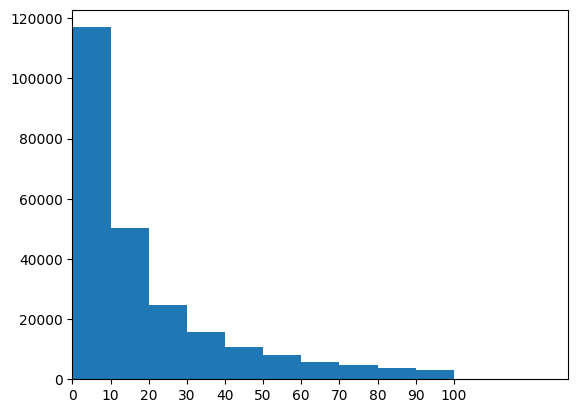

Done with plts:
Number of train users before random selection: 27256
Number of test users before random selection: 68048


KeyboardInterrupt: 

In [6]:
import ast
import random
import time

start_time = time.time()

#These set the rating requirements for test and train users.
TRAIN_USER_RATING_LB = 30
TRAIN_USER_RATING_UB = 50
TEST_USER_RATING_LB = 5
TEST_USER_RATING_UB = 10

#Number of users of each type to select:
NOF_TRAIN_BOUNDS = 5000
NOF_TEST_BOUNDS = 1000

SEED_INT = 2
# Seed for consistent results across runtimes:
random.seed(SEED_INT)


def populate_names(item):
    """Extract names from the syntax of certain data entries:"""
    string  = item[1:-1]
    jsons = string.split("}, ")   
    names = ""
    index = 0
    for item in jsons:
        if(index == len(jsons)-1):
            temp_dict = ast.literal_eval(item)
            names+=str(temp_dict["name"])
        else:
            temp_dict = ast.literal_eval(item+"}")
            names+=str(str(temp_dict["name"])+" ")
        index += 1
    return names


def provide_data(row):
    """Extract data from row of complete_list:"""
    movie_data = []
    movie_data.append(int(row[0]))
    movie_data.append(int(row[1]))
    movie_data.append(float(row[2]))
    movie_data.append(row[3])  

    movie_data.append(populate_names(row[4]))
    movie_data.append(populate_names(row[5]))
    movie_data.append(populate_names(row[6]))
    movie_data.append(populate_names(row[7]))

    movie_data.append(str(row[8]))
    movie_data.append(str(row[9]))
    return movie_data
    


# The list of rows with users id, the users rating for the movie, and raw data for the movie:
# Note: It is sorted by user_id.
complete_list = complete_df.values.tolist()

print("Complete number of users:", len(list(complete_df["userId"].unique()))) # 260788

# The complete list of user rows without ratings of the same movie more than once for a given user:
complete_list_no_dups = []

# Distinquish the user the row belongs to:
last_id = complete_list[0][0]

# The set of movies that a user has rated:
# It is used to omit later ratings of a movie that the user has already rated.
movie_set = set()

# The number of rows of movie data a single user takes up for each user:
gaps = []

# Appended to gaps when all of a users rows of movie data have been counted:
gap_len = 0


# Populates gaps and complete_list_no_dups by omitting movies that already have a rating in respect to each user:
# Note: This code is faster than using dataframe methods.
# Example: Filter data by user and then remove duplicate movie ids for each user.
# This avoids slow dataframe iteration, but the filter method is also slow.
for row in complete_list:
    if last_id != row[0]:
        movie_set= set()
        complete_list_no_dups.append(row)
        movie_set.add(row[1])
        gaps.append(gap_len)
        gap_len = 1
    else:
        if row[1] not in movie_set:
            complete_list_no_dups.append(row)
            gap_len+=1
            movie_set.add(row[1])
    last_id = row[0]

# Add the last gap_len:
gaps.append(gap_len)


#LOOK: New histogram of the number of ratings...
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist

less_than_ten = 0
less_than_tw = 0
for item in gaps:
    if item>=0 and item<10:
        less_than_ten+=1
    if item>=10 and item<20:
        less_than_tw+=1
    
print(less_than_ten)
print(less_than_tw)


hist(gaps, bins = 10, range = (0, 100))
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xlim(0, 130)
plt.show()
print("Done with plts:")

# Index in the complete_list_no_dups list:
full_index = 0 
# The start and end indices+1 of the users movies in complete_list_no_dups for each train user:
bounds_train = [] 
# The start and end indices+1 of the users movies in complete_list_no_dups for each test user:
bounds_test = [] 


# Populates bounds_train and bounds_test by testing each user if they are a valid train or test user:
for user_index in range(len(gaps)):
    if TRAIN_USER_RATING_LB <= gaps[user_index] and TRAIN_USER_RATING_UB >= gaps[user_index]:
        bounds_train.append([full_index, full_index+gaps[user_index]])

    elif TEST_USER_RATING_LB <= gaps[user_index] and TEST_USER_RATING_UB >= gaps[user_index]:
        bounds_test.append([full_index, full_index+gaps[user_index]])

    full_index+=gaps[user_index]    



# Question: Why save bounds of the users movie indices instead of just storing movie information for each movie rated by each user???
# Answer: The current code saves time and memory.
# It is redundant to save all the movie information when only a subset of the train and test users will be selected below.

print("Number of train users before random selection:",len(bounds_train)) 
print("Number of test users before random selection:", len(bounds_test)) 


bounds_train_sample = random.sample(bounds_train, NOF_TRAIN_BOUNDS)
bounds_test_sample = random.sample(bounds_test, NOF_TEST_BOUNDS)


# Transformed data of the selected train users and test users (in that order):
sampled_data = []


cnt = 0

for bound in bounds_train_sample:
    for movie in complete_list_no_dups[bound[0]:bound[1]]:
        movie_data = provide_data(movie)
        movie_data[0] = cnt
        sampled_data.append(movie_data)
    cnt+=1

for bound in bounds_test_sample:
    for movie in complete_list_no_dups[bound[0]:bound[1]]:
        movie_data = provide_data(movie)
        movie_data[0] = cnt
        sampled_data.append(movie_data)
    cnt+=1


print("Minutes taken:", (time.time()-start_time)/60)


#LOOK: need to explain the tradeoff between more data to feed the model (for svd and weighted average)
#and misrepresentation for the test users with smaller number of provided ratings uthan the train users 


#LOOK: Why do we need to filter users by the number of movies they rated when a certain lower number of ratings can be taken from users with more than enough ratings???

#Answer: the normal user that enters rating on this sight has to a profound propotion less than 10 ratings and the distribution is right skewed.
# so if we need to collect 30 ratings for a train user it is more normal to take from users with exactly that amount 
# becasue 30 ratings is the most normal user type that has 30 ratings
# for test users being in the range of 5-10, that is right on the nose for normal users so those users donot need to be altered



# Results, tested on personal machine:

# TRAIN_USER_RATING_LB = 50, TRAIN_USER_RATING_UB = 70
# TEST_USER_RATING_LB = 5, TEST_USER_RATING_UB = 10
# Complete number of users: 260788
# Number of train users before random selection: 14314
# Number of test users before random selection: 68048
# Minutes taken: 4.779916667938233

# TRAIN_USER_RATING_LB = 30, TRAIN_USER_RATING_UB = 50
# TEST_USER_RATING_LB = 5, TEST_USER_RATING_UB = 10
# Complete number of users: 260788
# Number of train users before random selection: 27256
# Number of test users before random selection: 68048
# Minutes taken: 3.207816179593404

# TRAIN_USER_RATING_LB = 11, TRAIN_USER_RATING_UB = 31
# TEST_USER_RATING_LB = 5, TEST_USER_RATING_UB = 10
# Complete number of users: 260788
# Number of train users before random selection: 70880
# Number of test users before random selection: 68048
# Minutes taken: 1.6583004673322042


## Write Data

Save selected data in constructed_data.csv file so that cells below it can run without running this cell and above.


In [ ]:
import csv
import os

current_directory = os.getcwd()
final_directory = os.path.join(current_directory, 'constructed_data')
if not os.path.exists(final_directory):
   os.makedirs(final_directory)

with open("constructed_data/constructed_data.csv", "w", encoding="utf-8", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['userId','id','rating',"title", "genres","production_companies","keywords", "cast", "tagline", "overview"])
    writer.writerows(sampled_data)

## Read Data
This is the starting cell to run if the data is already saved to the constructed_data.csv. 

In [ ]:
import csv

data_list =[]

with open("constructed_data/constructed_data.csv", 'r', encoding="utf-8") as f:
    csv_reader = csv.reader(f)
    data_list = list(csv_reader)

data_list = data_list[1:]


## Format and re-sample Data:

Format the data into a list of movie data rows for each movie rated for the user for each user. Then, select a subset of that data for each user type.

In [ ]:
import random

#Test user rating bounds.
TEST_USER_RATING_LB = 5
TEST_USER_RATING_UB = 10

#Number of selected users to move onto the model code.
NOF_TRAIN_USERS = 5000
NOF_TEST_USERS = 1000


SEED_INT = 2
# Seed for consistent results across runtimes:
random.seed(SEED_INT)

# These are lists of user data:
# Each entry in each list contains movie data for all the movies they rated.
user_to_data_train = []
user_to_data_test = []

# Distinquish the user the row belongs to:
user_id = data_list[0][0]

# Ratings of movies for a user:
ratings = []


# For each user, distinuish whether they are a train or test user by the number of their corresponding movie rows:
# Each movie entry for a user will be in consecutive rows in data_list becuase data_list is sorted by user.
# Note: Technically in the third cell there is clearly distinquished test and train users before combining them in sampled_data...
# so there is an arguably redundant processes here.
# However, this cell executes instantly so there is no need to persist any user type labels.
for row in data_list:
    if (row[0]!=user_id):
        if(TEST_USER_RATING_LB <= len(ratings) and TEST_USER_RATING_UB >= len(ratings)):
            user_to_data_test.append(ratings)
        else:
            user_to_data_train.append(ratings)
        user_id = row[0]
        ratings = [row]
    else:
        ratings.append(row)


# Distinuish whether the last user in the datalist a test or train user:
if(TEST_USER_RATING_LB <= len(ratings) and TEST_USER_RATING_UB >= len(ratings)):
    user_to_data_test.append(ratings)
else:
    user_to_data_train.append(ratings)




# This is where smaller or equal samples of train and test users are selcted from constructed_data.csv.
# Note: Suppose you execute (cell 3) for a excessive amount of train and test users and they are saved in constructed_data.csv.
# Then the cell above (cell 5) and this cell(cell 6) can be executed to select a smaller subset of those to use for the model...
# without having to run the relatively slow (cell 3) over again.
user_to_data_train = random.sample(user_to_data_train, NOF_TRAIN_USERS)
user_to_data_test = random.sample(user_to_data_test, NOF_TEST_USERS)


## Create Features and Target values

* The train and test version of feature 1,2, and 3 are populated and in the final cell some subset of (feature 1, 2 and 3) is used to train and test the final model.
* The target values are ratings for each user from the randomly selected movie that they rated. They are also either train or test ratings used to train or test the the final model.


In [ ]:
from gensim.parsing.preprocessing import remove_stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
import random
from ordered_set import OrderedSet
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import KMeans
import time

start_time = time.time()

#Number of selected components for each element of the svd factorization.
N_VALUE_1 = 10
N_VALUE_2 = 15

SEED_INT = 2
# Seed for consistent results across runtimes:
random.seed(SEED_INT)


class user_type_vars():
    """Each of the variables in this class represent the data structures for a user type."""
    def __init__(self):
        # For each user, a dictionary of movie_id to the movies rating for each movie the user watched:
        self.user_to_movie_id_to_rating = [] 

        # For each user, a random choice of movie_id from all the movies the user watched to represent the target movie:
        self.user_to_target_movie_id = [] 

        # For each user, this is the index of the users target movie in the order of train.movies_in_order.
        # (train_users only)
        self.user_to_target_index_full = [] 

        # For each user, includes ratings for all the movies in the entire train set in the order of movies_in_order:
        # Missing ratings and target movie ratings are set to that movies average rating.
        # (train_users only)
        self.user_to_ratings_full = [] 

        # For each user, includes ratings for all the movies in the entire train set in the order of movies_in_order:
        # The movies mean rating is subtracted from each rating.
        # Missing ratings and target movie ratings are set to zero.
        # (train_users only)
        self.user_to_ratings_full_transform = []

        # This is a set of every unique target movie for the train set.
        # This is used to check if a movie is in the train set but only as a target movie.
        # (train_users only)
        self.target_movies = set()

        # For every movie watched by the user_type, a list of ratings:
        self.movie_id_to_ratings = dict()

        # All the movie ids in the order of where they appear first in the list of user ratings (either train or test users): 
        self.movies_in_order = OrderedSet()

        # Model input features x for each user:
        self.feature_1 = []
        self.feature_2 = []
        self.feature_3 = []

        # Model output feature y for each user:
        self.user_to_target_rating  = [] 


# "user_type_vars" can represent a group of train users and a group of test users.
train_users = user_type_vars()
test_users = user_type_vars()


wnl = WordNetLemmatizer()



def load_feature_1_and_2(target_movies, movies_in_order, user_to_data, movie_id_to_ratings, user_to_movie_id_to_rating, user_to_target_movie_id, user_to_target_rating, feature_1, feature_2):
    """
    This is ran once to be used to populate features 1 and 2 for the train_users...
    and ran again to be used to populate features 1 and 2 for the test_users.
    It also populates the train and test version of these variables: target_movies, movies_in_order, movie_id_to_ratings,...
    user_to_movie_id_to_rating, user_to_target_movie_id, user_to_target_rating.
    These variables are used in the load_feature_3 function.
    """ 
    # "overall_rating_sum" and "overall_rating_count" are used to calculate the overall train rating.
    # The overall_average_train (which is overall_rating_sum/overall_rating_count) is only set to the output of the "train" function call.
    # This is used to fill in ratings for movies that are only target movies for a certain set of users.
    # This is because in practice and full application of the program/model, the target movie ratings are unknown (they need to be predicted).
    overall_rating_sum = 0
    overall_rating_count = 0

    for i in range(len(user_to_data)):
        movie_id_to_words = dict()
        movie_id_to_rating = dict()
        index = 0
        rand_index = random.randint(0, len(user_to_data[i])-1)
        for movie_data in user_to_data[i]:
            if index == rand_index:    
                target_movies.add(movie_data[1])
                user_to_target_movie_id.append(movie_data[1])
            else:
                # The program should train and test while simulating the possibility of...
                # some new movies having no existing rating data in the database.
                # This is critical training and testing if the resulting model were to realistically be tried on completely new data...
                # where target ratings are unknown (they need to be predicted).
                
                # This is why target ratings are omitted from movie_id_to_ratings.
                # The same logic stands for overall_average_train which is formed by overall_rating_sum and overall_rating_count.
                overall_rating_sum += float(movie_data[2])
                overall_rating_count += 1

                if movie_data[1] in movie_id_to_ratings.keys():
                    movie_id_to_ratings[movie_data[1]].append(float(movie_data[2]))
                else:
                    movie_id_to_ratings[movie_data[1]] = [float(movie_data[2])]

            movie_string = ""

            # Use this code to apply all the text data and combine in to a single list of words (repeats allowed).
            for j in range (3,len(movie_data)):
                if(j!= len(movie_data)-1):
                    movie_string+= movie_data[j]+" "
                else:
                    movie_string+= movie_data[j]


            # Use this truncated code to only include the genre column strings.
            # movie_string = movie_data[4]

            # Lematization and conversion to lists of words:
            cleaned_string = remove_stopwords(movie_string)
            cleaned_list = [wnl.lemmatize(word) for word in cleaned_string.split(" ")]
            cleaned_list = [word[:-1] for word in cleaned_list if word.endswith(".")] + [word for word in cleaned_list if not word.endswith(".")]

            movie_id_to_words[movie_data[1]] = cleaned_list
            movie_id_to_rating[movie_data[1]] = float(movie_data[2])
            movies_in_order.add(movie_data[1])
            index+=1

        user_to_movie_id_to_rating.append(movie_id_to_rating)

        # Question: This function assumes that all movies have their corpus information somewhere in selected portion of the "the-movies-dataset",...
        # inorder to make a word count vector.
        # What happens if with the application of this program/model, a completely new movie to the data is found???
        # Answer: Then feature_2 would not function as a model parameter and feature 3 would give worse performance, but feature 1 should still work fine.
        # Note: For the runtime of this notebook, since the train and test data all come from "the-movies-dataset" there is no risk of this happening.

        # The current users set of words from all the movies they rated:
        users_words_in_order = OrderedSet()
        for movie_id in movie_id_to_words.keys():
            users_words_in_order.update(movie_id_to_words[movie_id])

        # List of word counts in the order of users_words_in_order for each movie (excluding target movie):
        word_counts = []

        # Word counts in the order of users_words_in_order for the target movie:
        target_word_counts = [] 


        # Populate words_counts and target_word_counts
        # for movie_id in movie_id_to_words.keys():
        #     if movie_id != user_to_target_movie_id[-1]:
        #         temp_dict = Counter(movie_id_to_words[movie_id])
        #         temp_list = []
        #         for word in users_words_in_order:
        #             if word in temp_dict.keys():
        #                 temp_list.append(temp_dict[word])
        #             else:
        #                 temp_list.append(0)  
        #         word_counts.append(temp_list)  
        #     else:
        #         temp_dict = Counter(movie_id_to_words[movie_id])
        #         temp_list = []
        #         for word in users_words_in_order:
        #             if word in temp_dict.keys():
        #                 temp_list.append(temp_dict[word])             
        #             else:
        #                 temp_list.append(0) 
        #         target_word_counts = temp_list


        # Question: What if a list comprehension method was used instead of the above method???
        # Answer: The performance benefits remain indifferent even when the corpus columns are maxed out.
        # This code portion is not a bottleneck.

        # Populate words_counts and target_word_counts
        for movie_id in movie_id_to_words.keys():
            temp_dict = Counter(movie_id_to_words[movie_id])
            if movie_id != user_to_target_movie_id[-1]:
                word_counts.append([(lambda x : temp_dict[x] if x in temp_dict.keys() else 0)(word) for word in users_words_in_order])  
            else:
                target_word_counts = [(lambda x : temp_dict[x] if x in temp_dict.keys() else 0)(word) for word in users_words_in_order]


        # Construct the normalized tf-idf before applying cossine similairity/linear kernel: 
        # This places value on terms that are un-common in alot of documents,...
        # while still placing value on how common they are in the document at hand.
        # In this case documents are word counts for the corpuses of a single movie the user rated.
        # This should lead to a more powerful quantifier for cossine similairity/linear kernel between documents.

        complete_word_counts = word_counts.copy()
        complete_word_counts.append(target_word_counts)
        transformed_word_counts = TfidfTransformer().fit_transform(complete_word_counts).toarray()


        # Populate ratings without the target rating:
        ratings = []
        for movie_id in movie_id_to_rating.keys():
            if movie_id != user_to_target_movie_id[-1]:
                ratings.append(movie_id_to_rating[movie_id])
            else:
                # Add the target movie rating for the current user:
                # Each user has only one target movie rating.
                user_to_target_rating.append(movie_id_to_rating[movie_id])
    

        def predict():
            "Use the word counts and ratings to add predictions to feature_1 list and feature_2 list:"
            # Pred_1 is unweighted average of all of the users movies.
            pred_1 = sum(ratings) / len(ratings)
            # Pred_2 is weighted average of all the users movies (weights are based on (cossine similarity or linear kernel)),...
            # unless denominator is zero (see below).
            pred_2 = 0

            cosine_sim = linear_kernel(X = transformed_word_counts[0:-1],Y = [transformed_word_counts[-1]])
            cosine_sim = np.reshape(cosine_sim,  (len(cosine_sim)))
            numerator = 0
            denominator = 0
            pred_2 = pred_1

            #This prediciton is based on the premise that rating of the closest movie in terms #of textual data is a better prediction than the average of all the users ratings

            # highest_sim = -1
            # closest_rating = -1
            # for i in range(len(ratings)):
            #     if cosine_sim[i]> highest_sim:
            #         highest_sim = cosine_sim[i]
            #         closest_rating = ratings[i]
            # pred_2 = closest_rating


            #This prediction is based on the premise that movies that are closer...
            #in terms of textual data to the target movie shoud contribute more of there #weighted rating towards the the prediction of the target movies rating

            # for i in range(len(ratings)):
            #     numerator += cosine_sim[i]*ratings[i]
            #     denominator += cosine_sim[i]
    
            # # In case of potential division by zero:
            # if denominator != 0:
            #     pred_2 = numerator/denominator


            #LOOK: What about k-means clustering and then a weighted average for movies in the same cluster as the
            #target movie

            #LOOK: also make sure to do weigthed average of the movies in the same clusetr as the target if there are any

            k_means_preds = KMeans(n_clusters=4, random_state = SEED_INT, n_init="auto").fit_predict(transformed_word_counts)

            numerator = 0
            denominator = 0

            for i in range(len(k_means_preds)-1):
                if k_means_preds[len(k_means_preds)-1] == k_means_preds[i]:
                    numerator += ratings[i]
                    denominator+=1

            if denominator != 0:
                pred_2 = numerator/denominator

            return (pred_1, pred_2)
        
        predictions = predict()

        feature_1.append(predictions[0])
        feature_2.append(predictions[1])
            
        
    return overall_rating_sum/overall_rating_count

# Populate train data (feature 1 and feature 2):
# The overall_average_train, which is overall_rating_sum/overall_rating_count, is only set to the output of the "train" function call.
# This is used to fill in ratings for movies that are only target movies for a certain set of users.
overall_average_train = load_feature_1_and_2(train_users.target_movies, train_users.movies_in_order, user_to_data_train, train_users.movie_id_to_ratings, train_users.user_to_movie_id_to_rating, 
                                                         train_users.user_to_target_movie_id, train_users.user_to_target_rating, train_users.feature_1, train_users.feature_2)

# Populate test data (feature 1 and feature 2):
load_feature_1_and_2(set(), test_users.movies_in_order, user_to_data_test, test_users.movie_id_to_ratings, test_users.user_to_movie_id_to_rating, 
               test_users.user_to_target_movie_id,
               test_users.user_to_target_rating, test_users.feature_1, test_users.feature_2)


def pre_svd(movie_id_to_average_rating, movies_in_order, user_to_ratings_full_transform, user_to_ratings_full, user_to_target_index_full, 
               user_to_movie_id_to_rating, user_to_target_movie_id):
    """
    Populate the lists user_to_ratings_full and user_to_ratings_full_transform:
    User_to_ratings_full_transform is used for svd because it includes entries from all movies in movies_in_order...
    and transforms the data in user_to_ratings_full by subtracting the movie rating mean.
    This means that the transformed value at the indices of unwatched movies and index coresponding to target movies are zero.
    """
    for i in range(len(user_to_movie_id_to_rating)):
        ratings = []
        transformed_ratings = []

        # The index of the target movie within the entire "movies_in_order" ordered set:
        index = 0

        for movie_id in movies_in_order:
            if movie_id == user_to_target_movie_id[i]:
                user_to_target_index_full.append(index)
                ratings.append(movie_id_to_average_rating[movie_id])
                transformed_ratings.append(0) 
            elif movie_id in user_to_movie_id_to_rating[i].keys():
                ratings.append(user_to_movie_id_to_rating[i][movie_id])
                transformed_ratings.append(user_to_movie_id_to_rating[i][movie_id] - movie_id_to_average_rating[movie_id])
            else:
                ratings.append(movie_id_to_average_rating[movie_id])
                transformed_ratings.append(0)
            index +=1
        # "user_to_ratings_full" is just for demonstration.
        user_to_ratings_full.append(ratings)
        # "user_to_ratings_full_transform" is used.
        # Per movie averages have been subtracted (data is ready for svd).
        user_to_ratings_full_transform.append(transformed_ratings)


def svd_full(user_to_ratings_full_transform, n, movie_id_to_average_rating):
    """
    1. Get the svd of the user_to_ratings_full_transform 
    2. Truncate each factor to n components
    3. Multiply the truncated components together (U X s) X V 
    4. Scale back the values to the orginal rating scale (1-5) and return result
    """
    U, S, V = np.linalg.svd(user_to_ratings_full_transform, full_matrices=False)
    
    # Simplify factors to n components:
    U=U[:,0:n]
    S=np.diag(S)
    S=S[0:n,0:n]
    V=V[0:n,:]

    # Reconstruct to a new array:
    US = np.dot(U,S)
    USV = np.dot(US,V)

    # This tranforms the UsV row by row into the original rating scale (1-5).
    USV = USV + np.tile(list(movie_id_to_average_rating.values()), (USV.shape[0],1))

    # Be consistent with data structures:
    return list(USV)



def load_feature_3():
    """
    Populate feature_3 with a method loosely outlined here:
    1. Find the average ratings for movies 
    2. Pre_svd writes a rating for every movie for every user as well as a transformed version of those rating using the averages found above
    3. Then use the output of the svd_full function by row for user and by column for the target movie rating prediction
    """

    # Every movie ever seen by any user in either the test and train sets:
    all_movies_in_order = train_users.movies_in_order|test_users.movies_in_order


    # When a movie has a number of target ratings and non-target ratings, then only the non-target ratings are used...
    # to form the movies average rating.

    # There is a difference between non-target ratings between "movie_id_to_average_rating_train" and "movie_id_to_average_rating_full".
    # "movie_id_to_average_rating_train" considers the train set and "movie_id_to_average_rating_full" considers the train and test set.

    # When a movie has only target ratings in either the train of full dataset,...
    # instead of using the mean of the actual target ratings for "movie_id_to_average_rating_train" or "movie_id_to_average_rating_full",...
    # the movies average rating takes on the value of overall_average_train.
    # This is used to simlulate the potential application of this model when there are movies to be rated for a new user that have no ratings in the existing data.

    # The code below deliniates two different averages for valid movies, a train average and a train+test or full average.
    # The train average is used to normalize the ratings of the movies for train users in the first pre_svd call.
    # The train+test averages are used to normalize the ratings of the movies for train+test users in the second pre_svd call.


    #LOOK: need to try different solvers

    movie_id_to_average_rating_train = dict()
    movie_id_to_average_rating_full = dict()

    for movie in all_movies_in_order:
        temp = 0
        if(movie in train_users.movie_id_to_ratings and movie in test_users.movie_id_to_ratings):
            for rating in train_users.movie_id_to_ratings[movie]:
                temp+=rating
            movie_id_to_average_rating_train[movie] = temp/len(train_users.movie_id_to_ratings[movie]) 

            for rating in test_users.movie_id_to_ratings[movie]:
                temp+=rating
            movie_id_to_average_rating_full[movie] = temp/(len(train_users.movie_id_to_ratings[movie])+len(test_users.movie_id_to_ratings[movie]))

        elif(movie in train_users.movie_id_to_ratings):
            for rating in train_users.movie_id_to_ratings[movie]:
                temp+=rating
            movie_id_to_average_rating_train[movie] = temp/len(train_users.movie_id_to_ratings[movie])
            movie_id_to_average_rating_full[movie] = movie_id_to_average_rating_train[movie]

        elif(movie in test_users.movie_id_to_ratings):        
            if(movie in train_users.target_movies):
                movie_id_to_average_rating_train[movie] = overall_average_train

            for rating in test_users.movie_id_to_ratings[movie]:
                temp+=rating
            movie_id_to_average_rating_full[movie] = temp/len(test_users.movie_id_to_ratings[movie])
        else:
            if(movie in train_users.target_movies):
                movie_id_to_average_rating_train[movie] = overall_average_train
                movie_id_to_average_rating_full[movie] = overall_average_train
            else:
                movie_id_to_average_rating_full[movie] = overall_average_train
   

    # Note: The three variables below are mirrored in the train_users object.
    # These variables are for the full set "all_movies_in_order".

    # All the ratings for the movies corresponding to the order of the ordered set, "all_movies_in_order", for each user.
    full_user_to_ratings_full = []
    # All the transformed ratings for the movies corresponding to the order of the ordered set, "all_movies_in_order", for each user.
    full_user_to_ratings_full_transform = [] 
    # For each user, the index of the target movie corresponding to the order of "all_movies_in_order".
    full_user_to_target_index_full = [] 


    # Combining the watched movies per user in this order (train and then test users):
    full_user_to_movie_id_to_rating  = train_users.user_to_movie_id_to_rating + test_users.user_to_movie_id_to_rating
    # Combining the id of the target movie per user in this order (train and then test users):
    full_user_to_target_movie_id = train_users.user_to_target_movie_id + test_users.user_to_target_movie_id


    # The two function calls below are used to populate user_to_ratings_full_transform, user_to_ratings_full, and user_to_target_index_full (both train and full versions). 
    # User_to_ratings_full_transform is scaled with the movie_id_to_average_rating (both train and full versions).

    pre_svd(movie_id_to_average_rating_train, train_users.movies_in_order, train_users.user_to_ratings_full_transform, train_users.user_to_ratings_full, 
            train_users.user_to_target_index_full, train_users.user_to_movie_id_to_rating, train_users.user_to_target_movie_id)

    pre_svd(movie_id_to_average_rating_full, all_movies_in_order, full_user_to_ratings_full_transform, full_user_to_ratings_full, full_user_to_target_index_full, 
                full_user_to_movie_id_to_rating, full_user_to_target_movie_id)


    # In practice, there is a train and a test set, the train set is a selection of what the database has on record.
    # The test data will usually be data that hasn't been seen before that can include any number of test users.
    # When "train_users.user_to_ratings_full_transform" is used as the input of the svd function below,...
    # "svd_out_train" is used to produce predictions used to train the model.
    # When "full_user_to_ratings_full_transform" is used as the input of the svd function below,...
    # "svd_out_full" is used to produce predictions used to test the models

    # Note: The second parameter to this function is refered to as n and depending on other parameters to the model, like the rating bounds of train users,...
    # the highest perfroming values of n can vary.

    svd_out_train = svd_full(train_users.user_to_ratings_full_transform, N_VALUE_1, movie_id_to_average_rating_train)
    svd_out_full = svd_full(full_user_to_ratings_full_transform, N_VALUE_2, movie_id_to_average_rating_full)


    # The smaller svd provides predictions used to train the model.
    train_users.feature_3 = [svd_out_train[i][train_users.user_to_target_index_full[i]] 
                            for i in range(len(train_users.user_to_ratings_full_transform))]
    
    # The larger svd provides predictions used to test the model.
    test_users.feature_3 = [svd_out_full[i+len(train_users.user_to_ratings_full_transform)]
                            [full_user_to_target_index_full[i+len(train_users.user_to_ratings_full_transform)]] 
                            for i in range(len(full_user_to_ratings_full_transform) - len(train_users.user_to_ratings_full_transform))]


# populate train and test data (feature 3):
load_feature_3()


print("Minutes taken:", (time.time()-start_time)/60)

# This is used to show how the features approximate the target rating.
print("Feature_1 to target comparison (train):")
print(train_users.feature_1[0:5])
print(train_users.user_to_target_rating[0:5])

print("Feature_1 to target comparison (test):")
print(test_users.feature_1[0:5])
print(test_users.user_to_target_rating[0:5])

print("Feature_2 to target comparison (train):")
print(train_users.feature_2[0:5])
print(train_users.user_to_target_rating[0:5])

print("Feature_2 to target comparison (test):")
print(test_users.feature_2[0:5])
print(test_users.user_to_target_rating[0:5])

print("Feature_3 to target comparison (train):")
print(train_users.feature_3[0:5])
print(train_users.user_to_target_rating[0:5])

print("Feature_3 to target comparison (test):")
print(test_users.feature_3[0:5])
print(test_users.user_to_target_rating[0:5])


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jackson\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Minutes taken: 22.978208303451538
Feature_1 to target comparison (train):
[4.393939393939394, 3.388888888888889, 3.9069767441860463, 4.0, 3.4183673469387754]
[2.0, 4.0, 4.5, 5.0, 4.5]
Feature_1 to target comparison (test):
[3.625, 4.857142857142857, 2.625, 4.25, 4.166666666666667]
[3.0, 5.0, 4.0, 3.5, 4.0]
Feature_2 to target comparison (train):
[4.333333333333333, 3.2, 3.857142857142857, 4.090909090909091, 3.5714285714285716]
[2.0, 4.0, 4.5, 5.0, 4.5]
Feature_2 to target comparison (test):
[4.0, 5.0, 2.625, 4.25, 4.5]
[3.0, 5.0, 4.0, 3.5, 4.0]
Feature_3 to target comparison (train):
[4.1503734065246665, 3.7275629670165853, 3.958500459207009, 4.206196355010324, 4.071214073166197]
[2.0, 4.0, 4.5, 5.0, 4.5]
Feature_3 to target comparison (test):
[3.6841459104796557, 4.216672713247493, 4.218416952002084, 3.5471841142991476, 3.538181938182648]
[3.0, 5.0, 4.0, 3.5, 4.0]


## Final Model Creation

Certain features and the target ratings constructed above are used to train and test models with consistent parameters for a number of runs.

Note: each feature can function as a predictor to the target movies rating on their own. The purpose of the model (loosley speaking) is how much weight to give to each feature for the optimal prediction.



In [ ]:
import random
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
# From testing, feature scaling was found not to improve performance in model performance or runtime
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
# The alternative evaluation metric:
from sklearn.metrics import mean_squared_error


#New imports:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time
# from skopt import BayesSearchCV

#Netflix prize metric:
from sklearn.metrics import mean_squared_error

start_time  = time.time()

NOF_RUNS = 1


#LOOK: All train users have much more movie ratings than test users, so the users average rating is being
#assumed to be a more reliable estimator 
#For the svd part, remember that traing was developed with taking svd outputs for users with the same number of movies...
#as user that were going to be tested but this resultedin in worse results.

#LOOK: Why do we need to filter users by the number of movies they rated when a certain lower number of ratings can be taken from users with more than enough ratings???

#LOOK: The process above might introduce slight selection bias since there is a range of number of movies that normal users rate.
#this is different from the range of movies that they watch

#LOOK: should start with observing a histogram of the number of watched movies for users




#Generate different layer combinations, a hyperparametr in the mlp rergessor model
nof_layers = 3
step_size = 5
min_nof_nodes = 5
max_nof_nodes = 15


layer_configs = []


#LOOK: revert this back to 3 layers and max nof nodes  = 15
for i in range(1,nof_layers+1):

    #set the number of hidden layers
    current_steps = [min_nof_nodes]*(i)

    #vary the values of the hidden layers
    for j in range(1, int(((max_nof_nodes-min_nof_nodes)/step_size)+1)**(i)+1):
        layer_configs.append(current_steps.copy())

        #update the correct layer by adding nodes equal to the parameter step_size
        #and reseting the nodes to the right of it to min_nof_nodes
        for k in range(i, -1, -1):
            if(j%(int(((max_nof_nodes-min_nof_nodes)/step_size)+1)**(k)) == 0):
                current_steps[i - k - 1] += step_size
                for l in range(i - k, i):
                    current_steps[l] = min_nof_nodes
                break


print(layer_configs)


MLP_LAYERS = {'hidden_layer_sizes':layer_configs}
SOLVERS = {'solver': ['lbfgs', 'sgd', 'adam']}

SEED_INT = 2
# Seed for consistent results across runtimes:
random.seed(SEED_INT)

def test_parameters(nof_runs, layers, train_input_features, test_input_features):
    """Test_parameters for a number of runs and return performance results:"""
    train_inputs = [list(pair) for pair in train_input_features]
    test_inputs = [list(pair) for pair in test_input_features]
    return average_results(nof_runs, layers, train_inputs, test_inputs)
    

def average_results(nof_runs, layers, train_inputs, test_inputs):
    """Average the performance results for a number of models with identical inputs:"""
    no_rounding = 0
    rounding = 0
    for _ in range(nof_runs):
        pair = train_and_test(layers, train_inputs, test_inputs)
        no_rounding+=pair[0]
        rounding+=pair[1]
    return no_rounding/nof_runs, rounding/nof_runs


def train_and_test(layers, train_inputs, test_inputs):
    """Build, train, and test a model, then return the performance metric:"""

    #This is where hyperparameter tuning may be helpful
    #Instead of passing layers as a single vector
    #pass it as a list of vectors to choose from

    # MLP model:
    clf = MLPRegressor(hidden_layer_sizes = [5, 5, 15],  max_iter = 1000, random_state = SEED_INT)

    # Linear regression model:
    # reg = LinearRegression()


    #Hyperparamter tuning:
    # clf = GridSearchCV(reg, layers)
    # clf = BayesSearchCV(reg, layers, random_state = SEED_INT)
    #clf = RandomizedSearchCV(reg, layers, random_state = SEED_INT)
    # clf = GridSearchCV(reg, layers)


    # Train model:
    clf.fit(train_inputs, train_users.user_to_target_rating)

    # Give the best parameters
    # only works with hyperparamter tuning wrapper
    # print(clf.best_params_)

    # Print importance of the different input features to the model:
    results = permutation_importance(clf, train_inputs, train_users.user_to_target_rating)
    importances = results["importances_mean"]
    print("Feature Importance scores:", "First feature:", importances[0],"Second feature:", importances[1])


    # Make predictions for test inputs:
    predictions = clf.predict(test_inputs)

    # Test with and without roundings:
    # Note: The actual ratings a user makes must be divisable by .5: 
    rounded_predictions = [round(item*2)/2 for item in predictions]


    # Evaluation metric 0:
    # return(mean_squared_error(test_users.user_to_target_rating, predictions, squared=False), 
    #     mean_squared_error(test_users.user_to_target_rating, rounded_predictions, squared=False))

    # Evaluation metric 1:
    return(r2_score(test_users.user_to_target_rating, predictions), 
        r2_score(test_users.user_to_target_rating, rounded_predictions))

    # Evaluation metric 2:
    # return(mean_squared_error(test_users.user_to_target_rating, predictions), 
    #    mean_squared_error(test_users.user_to_target_rating, rounded_predictions))





# The current test is to average performance metric scores (currently r2_score) from 100 models trained on the same inputs.
# The hidden layers are (10,10,5).
# Note: layers only work when the mlp model is used.

#LOOK: in the preliminary testing the number of runs is 100 to reduce the random varaition and make it ever more likely that the...
#best perfoming network is actually the best 

avg_scores = test_parameters(NOF_RUNS, MLP_LAYERS, 
    zip(train_users.feature_2, train_users.feature_3),
      zip(test_users.feature_2, test_users.feature_3))


print("Average r2_score without rounding:",avg_scores[0])
print("Average r2_score with rounded prediction to nearest .5 (note: the actual ratings a user makes must be divisable by .5):",avg_scores[1])

print("Minutes taken:", (time.time()-start_time)/60)







# Average r2_score with rounded prediction to nearest .5 (note: the actual ratings a user makes must be divisable by .5): 0.17836146508107842
# Minutes taken: 1.7588933110237122


#LOOK: Minutes taken: 2.2997989495595297 with grid search...


#LOOK: problem with scopt and baysian optimization and numpy
#https://stackoverflow.com/questions/76321820/how-to-fix-the-numpy-int-attribute-error-when-using-skopt-bayessearchcv-in-sci

#LOOK: for simplicity baysian search was not used because of a dependency problem

#LOOK: include this in readme: before this current code using optimization,...
#The older code tested 100 models per layer input to be sure to find the best performing parameter
#testing a model multiple times is slow when using grid and random search because you arn't omitting values that are
#not optimal unless you edit the list of hyperparameters (list of layer combination) which can be tedious
#instead just applying a constant group of layers testing for 100 iterations and then adjusting the weigth in hopes of improvemnt
#seemed to result int the best number of layers
#the outpu and best perfoming layer combination is different from the grid search and individual testing
#becasue eveyr single model is tested 100 times inthe previous code




#last test: 0.27316667102618564
#last test time taken: 0.9092089811960856

#using grid search: 
#last test: 0.2643778561521982 (pretty far from the 10,10,5 tested 100 times)
#minutes taken: 34.65241620937983

# Average r2_score without rounding: 0.20592712764101284 k = 3 (only genres)

# Average r2_score without rounding: 0.22799132329489913 k = 4 (more than genres)

[[5], [10], [15], [5, 5], [5, 10], [5, 15], [10, 5], [10, 10], [10, 15], [15, 5], [15, 10], [15, 15], [5, 5, 5], [5, 5, 10], [5, 5, 15], [5, 10, 5], [5, 10, 10], [5, 10, 15], [5, 15, 5], [5, 15, 10], [5, 15, 15], [10, 5, 5], [10, 5, 10], [10, 5, 15], [10, 10, 5], [10, 10, 10], [10, 10, 15], [10, 15, 5], [10, 15, 10], [10, 15, 15], [15, 5, 5], [15, 5, 10], [15, 5, 15], [15, 10, 5], [15, 10, 10], [15, 10, 15], [15, 15, 5], [15, 15, 10], [15, 15, 15]]
Feature Importance scores: First feature: 0.08565874158628399 Second feature: 0.3063740432487928
Average r2_score without rounding: 0.18597486094605786
Average r2_score with rounded prediction to nearest .5 (note: the actual ratings a user makes must be divisable by .5): 0.16555511916249332
Minutes taken: 0.019876519838968914
